In [32]:
import numpy as np
from models import DLDSwithControl, DeepDLDS, SimpleNN
from datasets import CdLDSDataGenerator
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
import util
import pandas as pd
from sklearn.decomposition import PCA

In [33]:
K = 2
control_size=1
generator = DLDSwithControl(CdLDSDataGenerator(K=K, D_control=control_size, fix_point_change=True, eigenvalue_radius=0.94, set_seed=2))

time_points = 1000

# generate toy data
X = generator.datasets.generate_data(time_points, sigma=0.00)
if K == 1:
    states = torch.ones(time_points, 1).squeeze()
else:
    states = generator.datasets.states_#[1:]

# z-score normalization
# X = (X - X.mean(axis=0)) / X.std(axis=0)

X1 = torch.tensor(X[:, :-1], dtype=torch.float32)
X2 = torch.tensor(X[:, 1:], dtype=torch.float32)

In [34]:
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1500,
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

# set theme of plotly
plotly_template = 'plotly_white'
px.defaults.template = plotly_template

fig3 = px.line(X.T,labels={'index':'time'}).update_layout(title='Synthetic Data from a single state system') #20210414_w7
fig3.update_xaxes(showline=True, linewidth=2, linecolor='grey')
fig3.update_yaxes(showline=True, linewidth=2, linecolor='grey')
fig3.show(config=config)

In [42]:
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1500,
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

# set theme of plotly
plotly_template = 'plotly_white'
px.defaults.template = plotly_template

fig3 = px.line(X.T,labels={'index':'time'}).update_layout(title='Synthetic Data from a two state system') #20210414_w7
fig3.update_xaxes(showline=True, linewidth=2, linecolor='grey')
fig3.update_yaxes(showline=True, linewidth=2, linecolor='grey')
def find_highlight_regions(states):
    regions = []
    start = None
    for i in range(len(states)):
        if states[i] == 1 and start is None:
            start = i
        elif states[i] == 0 and start is not None:
            regions.append((start, i - 1))
            start = None
    # If the states array ends with a 1, capture that region as well
    if start is not None:
        regions.append((start, len(states) - 1))
    return regions

# Identify the regions where states are 1
highlight_regions = find_highlight_regions(states)

# Add shaded regions (rectangles) to the plot for each highlight region
for region in highlight_regions:
    fig3.add_shape(
        type="rect",
        xref="x", yref="paper",
        x0=region[0], x1=region[1],
        y0=0, y1=1,
        fillcolor="lightyellow", opacity=1, line_width=0,
        layer="below"  # Place the shapes in the background
    )
fig3.show(config=config)

In [41]:

fig3 = px.line(generator.datasets.U_[:1,:].T,labels={'index':'time','value':'magnitude'}).update_layout(title='Control Signals') #20210414_w7
fig3.update_xaxes(showline=True, linewidth=2, linecolor='grey')
fig3.update_yaxes(showline=True, linewidth=2, linecolor='grey')

# Identify the regions where states are 1
highlight_regions = find_highlight_regions(states)

fig3.show(config=config)

In [20]:
import main_functions as mf


In [22]:
X.shape

(4, 1000)

In [29]:
n_iterations = 3000
alpha = 0.6
smooth = 0
update_c_type = 'inv'


fitted_of_model = mf.train_model_include_D(data=X, max_iter=n_iterations,params={
                                                'update_c_type': update_c_type, 'reg_term': alpha, 'smooth_term': smooth, 'num_iters': 10}, normalize_eig=False, num_subdyns=2)

print(f'model with alpha={alpha} and smooth={smooth} has been trained')

/lisc/user/akobian/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/lisc/user/akobian/.local/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars



Error = 2283174759.6729074
Error = 487868668.779787
Error = 248376084437.00546
Error = 542324594.4796224
Error = 450402772.30603135
Error = 479787761.5581649
Error = 591806117.3411472
Error = 847458933.6957436
Error = 2033708276.82029
Error = 31329469128.957
Error = 28221799203.32073
Error = 1281535585.2157176
Error = 5734790637.071872
Error = 1710010675096.698
Error = 8237645360.358219
Error = 4095464048.5702033
Error = 202984024869.66745
Error = 1441400318.9325705
Error = 1898912968.0119467
Error = 84607423343.59541
Error = 662791979.0425512
Error = 520594962.39157116
Error = 497299426.9809949
Error = 36084181.660317324
Error = 101742034.40285134
Error = 52877363.13711303
Error = 17940341.428345308
Error = 6334447.329538234
Error = 10282.531265187074
Error = 6290.958052942926
Error = 5115.1800066652095
Error = 3856.263227266551
Error = 2862.8289033048877
Error = 2121.2471186517832
Error = 1571.0138486908781
Error = 1174.4305744641488
Error = 881.4178479094855
Error = 666.928758896547

In [30]:
coefficients = pd.DataFrame(fitted_of_model[0].T)
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1500,
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

print(f'[{update_c_type}, smooth_term={smooth}, {n_iterations} iterations]')
fig2 = px.line(coefficients, title='dLDS learned coefficients', color_discrete_map={'0': 'green', '1': 'orange'}).update_layout(
    xaxis_title='time [s]', yaxis_title='magnitude', legend_title='state')
fig2.update_xaxes(showline=True, linewidth=2, linecolor='grey')
fig2.update_yaxes(showline=True, linewidth=2, linecolor='grey')
fig2.show(config=config)

[inv, smooth_term=0, 3000 iterations]


In [31]:
reco_data = mf.create_reco(X, fitted_of_model[0], fitted_of_model[1])
reco = pd.DataFrame(reco_data.T)
fig3 = px.line(reco,labels={'time':'time [s]', 'value':'normalized activity', 'variable':'neuron'}).update_layout(title='dLDS reconstruction of activity') #20210414_w7
fig3.update_xaxes(showline=True, linewidth=2, linecolor='grey')
fig3.update_yaxes(showline=True, linewidth=2, linecolor='grey')
fig3.show(config=config)

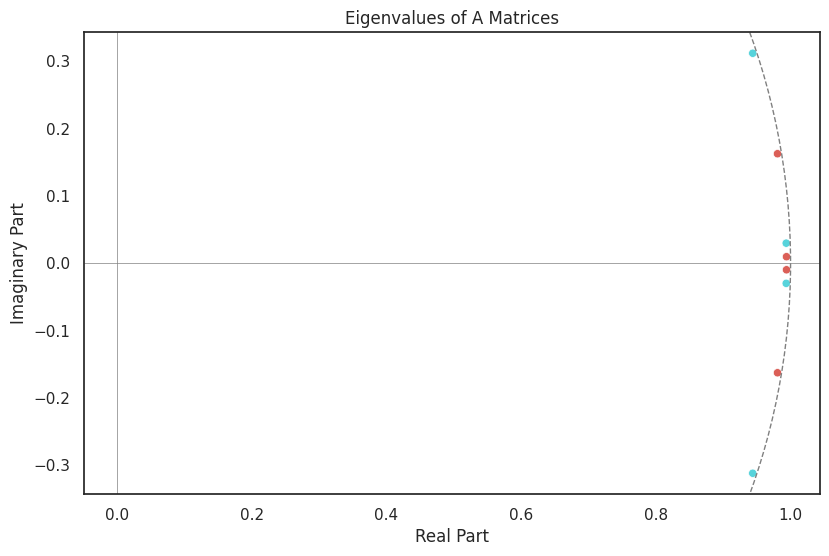

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import linalg

sns.set_theme(style="white")

plt.figure(figsize=(10, 6))

colors = {'1': 'red', '2': 'blue', '3': 'green', '4': 'purple'}  

data = []

for idx, f_i in enumerate(generator.datasets.A):
    eigenvalues, eigenvectors = linalg.eig(f_i)
    for eval_num, eigenval in enumerate(eigenvalues):
        data.append({'real': np.real(eigenval), 'imag': np.imag(eigenval), 'f': f'{idx+1}'})        
df = pd.DataFrame(data)

sns.scatterplot(data=df, x='real', y='imag', hue='f', alpha=1, palette=
                sns.color_palette("hls", len(generator.datasets.A)))     
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Eigenvalues of A Matrices')

# Add a unit circle
unit_circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(unit_circle)

# Set equal scaling to ensure the unit circle is round
plt.gca().set_aspect('equal', adjustable='box')

# dont show legend
plt.legend().remove()

# Show the plot
plt.show()
